In [1]:
import numpy as np
import os,sys,math, copy, pickle
from scipy.spatial import distance
from random import seed,random,randint
import pandas as pd
import matplotlib.pyplot as plt
#install lib
!pip install DeCida
from decida.Pattern import Pattern
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa as tsa
from scipy import signal
from scipy.fftpack import fft, fftfreq
import tmsd_codes as tmsd #PRBS, Auto and cross-correlation
plt.rcParams['figure.figsize'] = (16.0, 8.0)
#plt.rcParams['figure.figsize'] = [16, 8]
seed(1234)
np.random.seed(1234)

distributed 1.21.8 requires msgpack, which is not installed.
tensorflow 1.11.0 has requirement setuptools<=39.1.0, but you'll have setuptools 45.2.0 which is incompatible.
jupyterthemes 0.20.0 has requirement notebook>=5.6.0, but you'll have notebook 5.5.0 which is incompatible.
You are using pip version 10.0.1, however version 21.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Questão 1 - Simulando o sistema dado por uma entrada prbs

1024


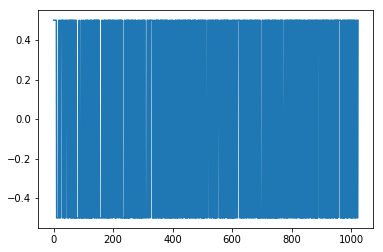

In [2]:
p = Pattern(v0=0,v1=1, delay=1, edge=1, period= 1, format = 'binary')
prbs = p.prbs(size = 10,length=1024)
prbs = [int(i)-0.5 for i in prbs]
print(len(prbs))
plt.plot(prbs)

- Cria sistema dado;
- Plota a saída do sistema para o sinal prbs;
- Corta o inicio do sinal como aconselhado na questão;
- Plota a saída;

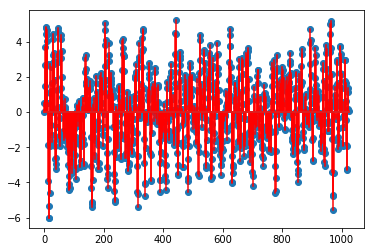

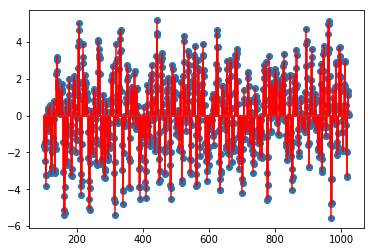

In [3]:
num = [1, 0.5]
den = [1, -1.5, 0.7]
sst = signal.TransferFunction(num, den, dt=1)
t, y = signal.dlsim(sst, prbs)
y = np.squeeze(y)

plt.stem(t, y, 'r-');
plt.show()
def cut_signal(y,t,prbs,c=100):
    #cortando o inicio
    y_c = y[c:]
    t_c = t[c:]
    prbs_c = prbs[c:]

    #subtraindo o sinal pela média
    y_c = y_c - np.mean(y_c)

    plt.stem(t_c, y_c, 'r-');
    plt.show()
    return y_c, t_c, prbs_c

y_c, t_c, prbs_c = cut_signal(y,t,prbs,c=100)

- Valores dos parametros calculados são 1.5 -0.7 1 0.5
- Estimados são apresentados abaixo, percebe-se a proximidade, com erro na terceira ou quarta casa decimal

In [4]:
def calc_apro(y_c, t_c, prbs_c):
    #minimos quadrados
    y_v = np.array(y_c[2:])
    y_v1 = np.array(y_c[1:-1])
    y_v2 = np.array(y_c[:-2])
    prbs_v1 = np.array(prbs_c[1:-1])
    prbs_v2 = np.array(prbs_c[:-2])

    #matriz pseudo inversa
    mpi = np.matrix([y_v1.T, y_v2.T, prbs_v1.T, prbs_v2.T]).T
    print(y_v.T.shape)
    teta = np.linalg.pinv(mpi).dot(y_v.T)

    print(teta[0])
    return teta[0]

teta = calc_apro(y_c, t_c, prbs_c)

(922,)
[[ 1.5000107  -0.70000887  0.99992612  0.49989269]]


### Questão 2 - Estimar modelo ARX para o processo escolhido

dimensão da entrada: (5000,)
Processamento Finalizado


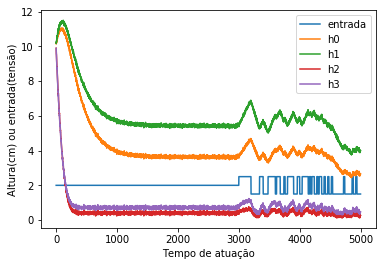

In [56]:
#função que implementa as equações diferenciais referente ao modelo do tanque quádruplo
def dvTanQua(x, uv1, uv2, t):
    A1,A2,A3,A4 = 32,28,32,28 #cm²
    alpha1,alpha2,alpha3,alpha4 = 0.071,0.071,0.071,0.071
    g = 981#cm²s⁻²
    k1, k2, kc = 3.33,3.33,0.5
    y1,y2 = 0.6, 0.7 #verificar esses valores
    xd = []
    #equação 1
    xd_0 = (-alpha1/A1) * np.sqrt(2*g*x[0]) + (alpha3/A1)*np.sqrt(2*g*x[2]) + ((y1*k1)/A1)*uv1
    xd.append(xd_0*kc)
    #equação 2
    xd_1 = (-alpha2/A2) * np.sqrt(2*g*x[1]) + (alpha4/A2)*np.sqrt(2*g*x[3]) + ((y2*k2)/A2)*uv2
    xd.append(xd_1*kc)
    #Equação 3
    xd_2 = (-alpha3/A3) * np.sqrt(2*g*x[2]) + (((1 - y2)*k2)/A3)*uv2
    xd.append(xd_2)
    #Equação 4
    xd_3 = (-alpha4/A4) * np.sqrt(2*g*x[3]) + (((1 - y1)*k1)/A4)*uv1
    xd.append(xd_3)

    return xd


#Função que implementa o Runge–Kutta de quarta ordem 
def rkTanQua(x0, uv1, uv2, h, t):
    #1st evaluation
    xd = dvTanQua(x0, uv1, uv2, t)
    savex0 = x0.copy()
    phi = xd.copy()
    for i in range(len(x0)):
        x0[i] = savex0[i] + 0.5 * h * xd[i]

    #2nd evaluation
    xd = dvTanQua(x0, uv1, uv2, t + 0.5 * h)
    phi = (phi + 2 * xd)
    for i in range(len(x0)):
        x0[i] = savex0[i] + 0.5 * h * xd[i]

    #3rd evaluation
    xd = dvTanQua(x0, uv1, uv2, t + 0.5 * h)
    phi = phi + 2 * xd
    for i in range(len(x0)):
        x0[i] = savex0[i] + h * xd[i]

    #4th evaluation
    xd = dvTanQua(x0, uv1, uv2, t + h)

    result_x = x0.copy()
    for i in range(len(x0)):
        result_x[i] = savex0[i] + (phi[i] + xd[i]) * h / 6

    return result_x



t0 = 0
tf = 5000
h = 1
t = np.arange(t0, tf, h)

#setando valores de pontos iniciais são necessários para execução em questão
init_ = [10.1]

#executando simulação 
x_f = []
for point_stt in init_:
    x0 = np.array([[point_stt], [point_stt], [point_stt], [point_stt]])

dc = np.zeros((len(x0), len(t) - 1))
x = x0.copy()
x = np.append(x, dc, axis=1)
v = len(t) 

def dup(prbs, v=2):
    new_prbs = []
    for i in prbs:
        for j in range(v):
            new_prbs.append(i)
    return new_prbs

prbs = p.prbs(size = 10,length=100)
prbs = [int(i)+1.5 for i in prbs]

prbs = dup(prbs, v=20)

u = ([2]*(len(t)-len(prbs))) + prbs #signal_super(t,gains, b)
u = np.array(u)
print('dimensão da entrada: {}'.format(u.shape))
for k in range(1, len(t)):
    result = rkTanQua(x[:, k - 1], u[k], u[k], h, t[k])
    x[:, k] = result
print('Processamento Finalizado')

#função para plotar os resultados
def plotsignals(signals,ref,t, name_input,init_):
    l, = plt.plot(t,ref, label='entrada')
    for idx,sig in enumerate(signals):
        l, = plt.plot(t, sig, label='h'+str(idx))
        #plt.stem(t, sig, 'r-');
    #plt.legend([name_input,'h1_sign_'+str(idx),'h2_sign_'+str(idx),'h3_sign_'+str(idx),'h4_sign_'+str(idx)], loc='lower right')
    plt.legend(loc='upper right')
    plt.xlabel('Tempo de atuação')
    plt.ylabel('Altura(cm) ou entrada(tensão)')
    plt.show()


noise = np.random.normal(0, .05, u.shape)
x[0] = x[0] + noise
x[1] = x[1] + noise
x[2] = x[2] + noise
x[3] = x[3] + noise
    
plotsignals(x,u,t, 'superposição',init_)

- Retirando a parte de estabilização do sinal
- Colocando os sinais em torno do valor 0
- executando o algoritmo

Resultado:


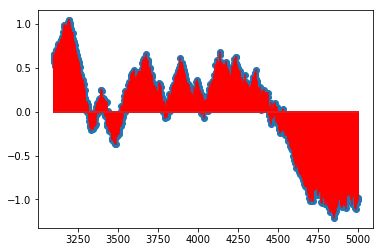

(1898,)
[[0.45843132 0.53224478 0.00199579 0.01564596]]


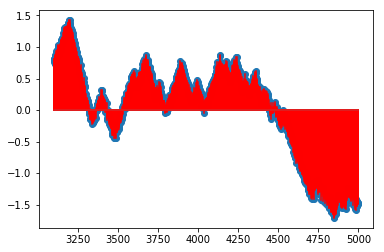

(1898,)
[[0.46234795 0.53156295 0.00690013 0.01554979]]


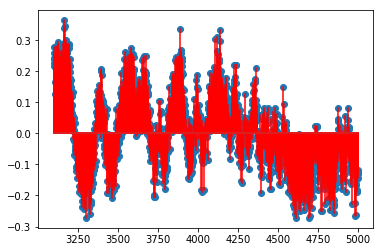

(1898,)
[[0.37227273 0.45395816 0.00337635 0.03039214]]


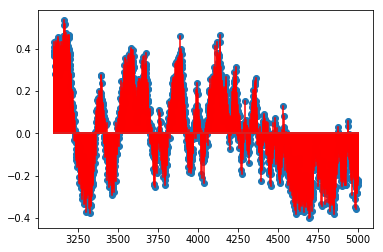

(1898,)
[[0.42130579 0.49634903 0.00958455 0.02252534]]


In [57]:
def red_sampling(data, rate_reduc):
    number_samp = len(data)
    samples_slct = list(range(0,number_samp,rate_reduc))
    new_data = data[samples_slct]
    return new_data

##Cortar o sinal para o inicio do teste

u_ = u[3000:]
t_ = t[3000:]
y = []
y.append(x[0][3000:])
y.append(x[1][3000:])
y.append(x[2][3000:])
y.append(x[3][3000:])

##reduzir valor para começar no 0
u_ = u_ - 2
y[0] = y[0] - y[0][0]
y[1] = y[1] - y[1][0]
y[2] = y[2] - y[2][0]
y[3] = y[3] - y[3][0]

##Diminuir o aumento do tempo de segurar o prbs
rate_reduc = 20
#u_ = red_sampling(u_, rate_reduc)
#t_ = red_sampling(t_, rate_reduc)
##y[0] = red_sampling(y[0], rate_reduc)
#y[1] = red_sampling(y[1], rate_reduc)
#y[2] = red_sampling(y[2], rate_reduc)
#y[3] = red_sampling(y[3], rate_reduc)


teta = []
print('Resultado:')
y_c, t_c, prbs_c = cut_signal(y[0],t_,u_,c=100)
teta.append(calc_apro(y_c, t_c, prbs_c))
y_c, t_c, prbs_c = cut_signal(y[1],t_,u_,c=100)
teta.append(calc_apro(y_c, t_c, prbs_c))
y_c, t_c, prbs_c = cut_signal(y[2],t_,u_,c=100)
teta.append(calc_apro(y_c, t_c, prbs_c))
y_c, t_c, prbs_c = cut_signal(y[3],t_,u_,c=100)
teta.append(calc_apro(y_c, t_c, prbs_c))

- Plot entre o valor aproximado e o sinal real. Percebe-se uma aproximação muito boa, o que torna a aproximação aceitável.

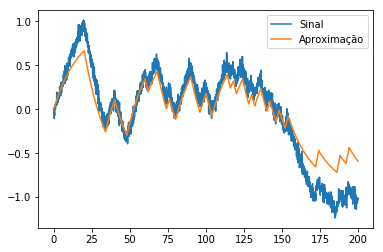

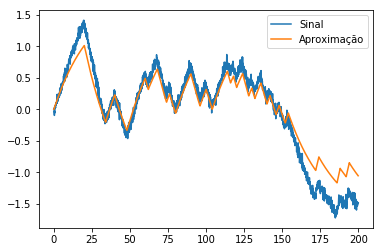

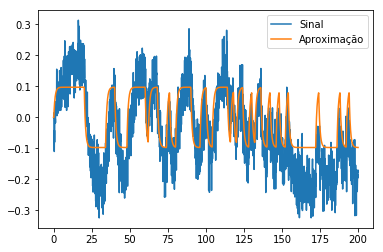

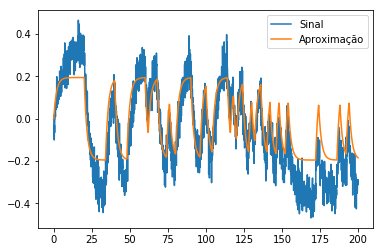

In [61]:
for i,tt in enumerate(teta):
    num = [tt[0,2], tt[0,3]]
    den = [1,-tt[0,0], -tt[0,1]]
    sst = signal.TransferFunction(num, den, dt=0.1)
    t, y_ = signal.dlsim(sst, u_)
    y_ = np.squeeze(y_)
    plt.plot(t, y[i], label = 'Sinal')
    plt.plot(t, y_, label = 'Aproximação')
    plt.legend()
    plt.show()

### Avaliando comportamento em outro ponto de operação

- Percebe-se que a aproximação é muito boa para o sinal que foi aproximado, porém não se comporta muito bem com outro ponto de operação. Esse resultado é esperado. Pois o método é voltado para os pontos utilizados no treinamento.

dimensão da entrada: (5000,)
Processamento Finalizado


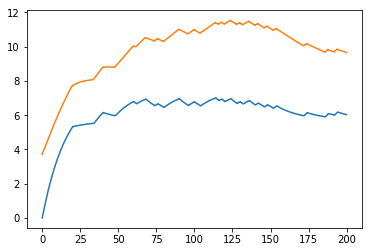

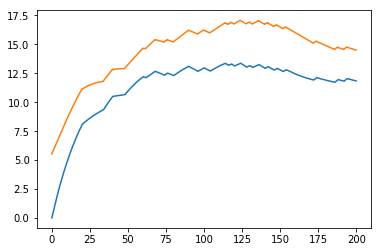

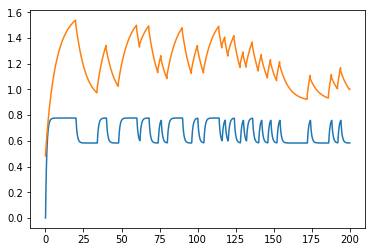

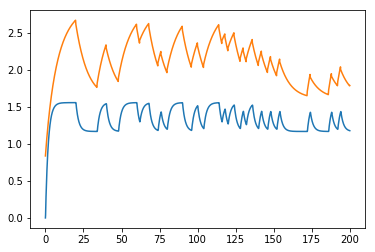

In [59]:
tf = 5000
h = 1
t = np.arange(t0, tf, h)

#setando valores de pontos iniciais são necessários para execução em questão
init_ = [10.1]

#executando simulação 
x_f = []
for point_stt in init_:
    x0 = np.array([[point_stt], [point_stt], [point_stt], [point_stt]])

dc = np.zeros((len(x0), len(t) - 1))
x = x0.copy()
x = np.append(x, dc, axis=1)
v = len(t) 

def dup(prbs, v=2):
    new_prbs = []
    for i in prbs:
        for j in range(v):
            new_prbs.append(i)
    return new_prbs

prbs = p.prbs(size = 10,length=100)
prbs = [int(i)+3 for i in prbs]

prbs = dup(prbs, v=20)

u = ([2]*(len(t)-len(prbs))) + prbs #signal_super(t,gains, b)
u = np.array(u)
print('dimensão da entrada: {}'.format(u.shape))
for k in range(1, len(t)):
    result = rkTanQua(x[:, k - 1], u[k], u[k], h, t[k])
    x[:, k] = result
print('Processamento Finalizado')

u = u[3000:]
for i,tt in enumerate(teta):  
    num = [tt[0,2], tt[0,3]]
    den = [1,-tt[0,0], -tt[0,1]]
    sst = signal.TransferFunction(num, den, dt=0.1)
    t, y_ = signal.dlsim(sst, u)
    y_ = np.squeeze(y_)
    plt.plot(t, y_)
    plt.plot(t, x[i][3000:])
    plt.show()